## Подключение к SQLite из Jupyter Notebook

SQLite — это встроенная в Python база данных, не требующая установки.
Для подключения в Jupyter Notebook используем модуль `sqlite3`

In [31]:
import pandas as pd
import sqlite3
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

In [2]:
# В файле нет названия колонок, поэтому задаем их вручную
df = pd.read_csv(r'C:\Users\1\Desktop\Курсы\Стажировки\Стажка яндекс\Продуктовый аналитик\data.tsv', sep="\t",  header=None, names=["query", "timestamp", "platform"])

# Переведем столбец с датой в формат datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

# Создаём соединение с SQLite в памяти
conn = sqlite3.connect(":memory:")

In [12]:
# Записываем DataFrame в таблицу queries
df.to_sql("queries", conn, index=False, if_exists="replace")

# Посмотрим содержимое
query = """
SELECT query, timestamp, platform
FROM queries
"""

df = pd.read_sql(query, conn) 
df.head(10)

,query,timestamp,platform
0,порно фото,2021-09-16 10:04:57,touch
1,малевич картины,2021-09-16 15:34:25,desktop
2,Секс,2021-09-16 08:39:43,touch
3,с днём рождения лена,2021-09-16 05:52:43,touch
4,зверополис порно,2021-09-16 10:19:59,touch
5,алабай собака фото,2021-09-16 10:04:05,touch
6,бактериофаг,2021-09-16 18:16:42,desktop
7,полина гагарина,2021-09-16 14:53:25,touch
8,кадр из фильма,2021-09-16 05:40:37,desktop
9,porno,2021-09-16 08:25:41,touch


## Задание 1 — Диапазон дат 
Необходимо определить, за какой период предоставлены данные.
Для этого находим минимальную и максимальную дату в датасете `data.tsv`.

In [13]:
diapozon = """
SELECT MAX(timestamp) as maximum, MIN(timestamp) as minimum FROM queries
"""

interval = pd.read_sql(diapozon, conn)

max_date, min_date, = interval.iloc[0]
first_task = f'Дата начала: {min_date},  Дата конца: {max_date}'
print(first_task)



Дата начала: 2021-08-31 21:00:00,  Дата конца: 2021-09-21 20:59:59


## Задание 2 — Количество запросов с текстом "ютуб" по платформам

Фильтруем строки, где `query` содержит подстроку `"ютуб"`,  
группируем по колонке `platform` и считаем количество запросов для каждой из них (`desktop`, `touch`).

In [50]:
youtube = """
SELECT platform, count(query) as kolvo
FROM queries
WHERE query like '%ютуб%' or query like '%Ютуб%'
group by platform
"""

youtube_kolvo = pd.read_sql(youtube, conn)
display(youtube_kolvo.style.hide(axis="index"))

platform,kolvo
desktop,806
touch,732


## Задание 3 — Топ‑10 самых частотных запросов в каждой платформе

Вывести 10 наиболее часто встречающихся запросов отдельно для `desktop` и `touch`.  
Сравнить полученные списки и определить отличия в популярных запросах между платформами.

Сначала выведем 10 наиболее частотных запросов для платформы `desktop`.


In [6]:
desktop_top = """
SELECT query, COUNT(query) as kolvo_zaprosov FROM queries
WHERE platform = 'desktop'
GROUP BY query
order by kolvo_zaprosov desc
LIMIT 10
"""

top_10_desktop = pd.read_sql(desktop_top, conn)
display(top_10_desktop.style.hide(axis="index"))

query,kolvo_zaprosov
календарь 2021,2804
таблица менделеева,2631
картинки,1647
порно,1342
английский алфавит,1293
обои на рабочий стол,1143
Одноклассники (социальная сеть),1116
секс,895
таблица квадратов,877
алфавит,874


**Теперь построим Линейчатую Диаграмму**

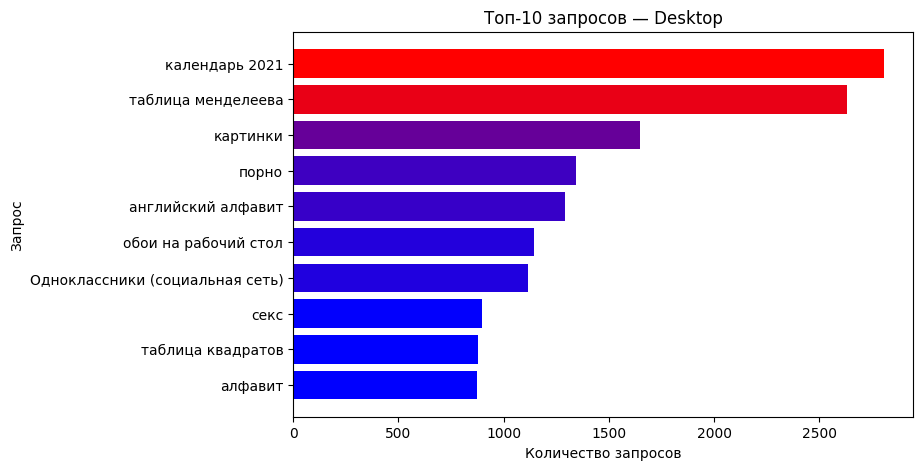

In [7]:
norm = plt.Normalize(top_10_desktop["kolvo_zaprosov"].min(),
                     top_10_desktop["kolvo_zaprosov"].max())

blue_to_red = LinearSegmentedColormap.from_list("blue_red", ["blue", "red"])
colors = blue_to_red(norm(top_10_desktop["kolvo_zaprosov"]))

plt.figure(figsize=(8, 5))
plt.barh(top_10_desktop["query"], top_10_desktop["kolvo_zaprosov"], color = colors)
plt.xlabel("Количество запросов")
plt.ylabel("Запрос")
plt.title("Топ‑10 запросов — Desktop")
plt.gca().invert_yaxis() 
plt.show()

Теперь выведем 10 наиболее частотных запросов для платформы `touch`.

In [8]:
touch_top = """
SELECT query, COUNT(query) as kolvo_zaprosov FROM queries
WHERE platform = 'touch'
GROUP BY query
order by kolvo_zaprosov desc
LIMIT 10
"""

top_10_touch = pd.read_sql(touch_top, conn)
display(top_10_touch.style.hide(axis="index"))

query,kolvo_zaprosov
порно,7740
секс,6348
с днём рождения женщине,4903
с днём рождения,3967
с днём рождения мужчине,3623
хентай,3157
с днем рождения,3005
xxx,2429
Порно,2330
календарь 2021,2237


**Теперь построим Линейчатую Диаграмму**

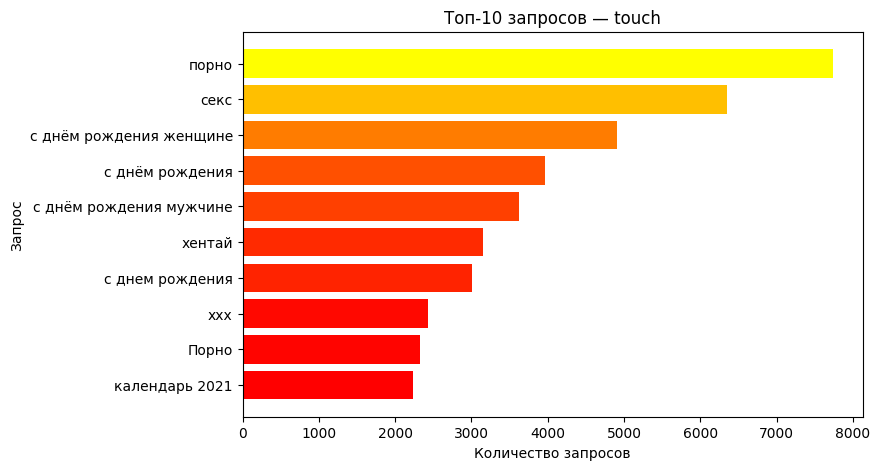

In [9]:
norm = plt.Normalize(top_10_touch["kolvo_zaprosov"].min(),
                     top_10_touch["kolvo_zaprosov"].max())

red_to_yellow = LinearSegmentedColormap.from_list("red_yellow", ["red", "yellow"])
colors = red_to_yellow(norm(top_10_touch["kolvo_zaprosov"]))

plt.figure(figsize=(8, 5))
plt.barh(top_10_touch["query"], top_10_touch["kolvo_zaprosov"], color = colors)
plt.xlabel("Количество запросов")
plt.ylabel("Запрос")
plt.title("Топ‑10 запросов — touch")
plt.gca().invert_yaxis() 
plt.show()

С `touch` преимущественно ищут контент для взрослых и поздравления с днём рождения,  
а с `Desktop`, помимо контента для взрослых, также ищут учебные материалы, картинки и оформление рабочего стола.

## Задание 4 — Анализ трафика запросов в течение дня

Построить графики распределения количества запросов по часам суток  
и определить, как меняется активность пользователей в разное время дня.  

In [10]:
sutki = """
SELECT strftime('%H', timestamp) as hour, COUNT(timestamp) as kolvo_zaprosov FROM queries
GROUP BY hour
"""

sutki_zaprosy = pd.read_sql(sutki, conn)
display(sutki_zaprosy.style.hide(axis="index"))

hour,kolvo_zaprosov
00,10018
01,12640
02,17522
03,27916
04,40779
05,57901
06,65536
07,68364
08,63599
09,65349


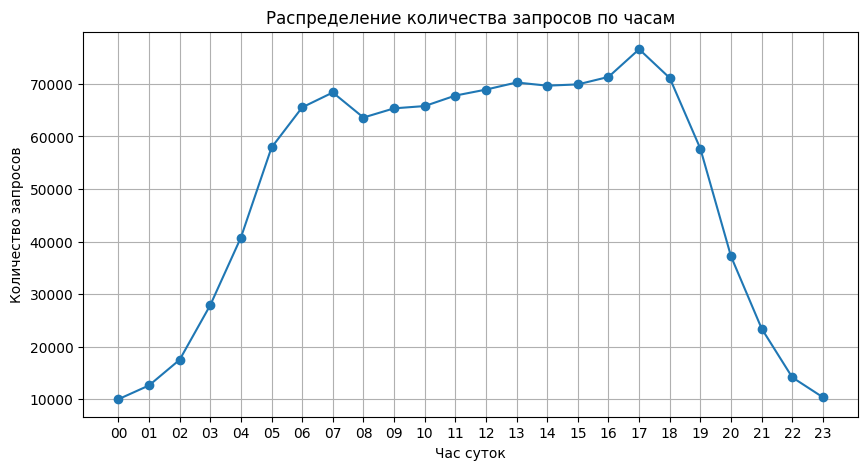

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(sutki_zaprosy["hour"], sutki_zaprosy["kolvo_zaprosov"], marker="o")
plt.xlabel("Час суток")
plt.ylabel("Количество запросов")
plt.title("Распределение количества запросов по часам")
plt.grid(True)
plt.show()

График запросов начинает расти с раннего утра, активно увеличивается уже с **3–4 часов**,  
когда в **Приморском крае** и **Сибири** начинается активная деятельность и рабочее время.  

С **7 до 17 часов** количество запросов держится на стабильном высоком уровне,  
формируя *«плато»* дневной активности. Этот период совпадает с **активным рабочим временем**  
в **Центральной России**, на **Урале**, **Юге** и в **Северо-Западном регионе**,  
где проживает основная часть населения страны.  

В **18:00** наблюдается **резкий всплеск**, что, вероятно, связано с окончанием рабочего дня или учёбы.  

После 18 часов трафик начинает постепенно снижаться, достигая **минимума** к ночи.  
Такое распределение можно объяснить тем, что большинство пользователей активнее всего  
используют поиск в рабочее и учебное время.

## Задание 5 - Тематики запросов, контрастные для мобильных и компьютеров

Для анализа различий между платформами были выделены ключевые категории запросов:  
**🔞 Контент 18+**, **🎮 Игры**, **🛒 Покупки**, **📚 Учёба**, **🎶 Музыка**, **🎂 Поздравления**, **👥 Развелечения** , **🌐 Соцсети**, **📱 Обои**, **✝️ Религия**, **🚗 Авто**, **🐶 Домашние животные** и **другие**.

In [28]:
category = """
WITH kolvo_platforms as 
(SELECT query, platform, COUNT(query) OVER(PARTITION BY platform) as vsego FROM queries),

tema as 
(SELECT query,
CASE
    WHEN LOWER(query) LIKE '%таблиц%' OR LOWER(query) LIKE '%алфавит%' OR LOWER(query) LIKE '%задани%' OR LOWER(query) LIKE '%школ%' THEN 'Учёба'
    WHEN LOWER(query) LIKE '%фильм%' OR LOWER(query) LIKE '%сериал%' OR LOWER(query) LIKE '%актер%' OR LOWER(query) LIKE '%актрис%' THEN 'Развлечения'
    WHEN LOWER(query) LIKE '%поздравлени%' OR LOWER(query) LIKE '%открытк%' THEN 'Поздравления'
    WHEN LOWER(query) LIKE '%одноклассник%' OR LOWER(query) LIKE '%вконтакт%' OR LOWER(query) LIKE '%телеграм%' THEN 'Соцсети'
    WHEN LOWER(query) LIKE 'xxx%' OR LOWER(query) LIKE '%секс%' OR LOWER(query) LIKE '%порн%' THEN 'Контент 18+'
    WHEN LOWER(query) LIKE 'игр%' OR LOWER(query) LIKE '%roblox%' OR LOWER(query) LIKE '%маинкрафт%' THEN 'Игры'
    WHEN LOWER(query) LIKE 'продукт%' OR LOWER(query) LIKE '%цен%' OR LOWER(query) LIKE '%одежд%' THEN 'Покупки'
    WHEN LOWER(query) LIKE 'клип%' OR LOWER(query) LIKE '%слуша%' OR LOWER(query) LIKE '%песн%' OR LOWER(query) LIKE '%музык%' THEN 'Музыка'
    WHEN LOWER(query) LIKE '%библия%' OR LOWER(query) LIKE '%икон%' OR LOWER(query) LIKE '%молитв%' THEN 'Религия'
    WHEN LOWER(query) LIKE '%kia%' OR LOWER(query) LIKE '%bmw%' OR LOWER(query) LIKE '%audi%' THEN 'Авто'
    WHEN LOWER(query) LIKE '%кошк%' OR LOWER(query) LIKE '%корг%' OR LOWER(query) LIKE '%собак%' THEN 'Домашние животные'
    WHEN LOWER(query) LIKE '%обо%' OR LOWER(query) LIKE '%картинк%' OR LOWER(query) LIKE '%фон%' THEN 'Обои'
    ELSE 'Другие'
END as tematika,
platform, vsego FROM kolvo_platforms),

tema_vsego as 
(SELECT platform, tematika, count(tematika) as kolvo_tema, vsego FROM tema
GROUP BY platform, tematika, vsego)

SELECT platform, tematika, ROUND(100.0 * kolvo_tema / vsego, 2) as procent FROM tema_vsego
ORDER BY platform, tematika
"""

categories = pd.read_sql(category, conn)
display(categories.style.hide(axis="index"))

platform,tematika,procent
desktop,Авто,0.120000
desktop,Домашние животные,0.420000
desktop,Другие,86.030000
desktop,Игры,0.200000
desktop,Контент 18+,1.410000
desktop,Музыка,0.140000
desktop,Обои,5.870000
desktop,Поздравления,0.890000
desktop,Покупки,0.190000
desktop,Развлечения,0.420000


**Построим Гистограмму**

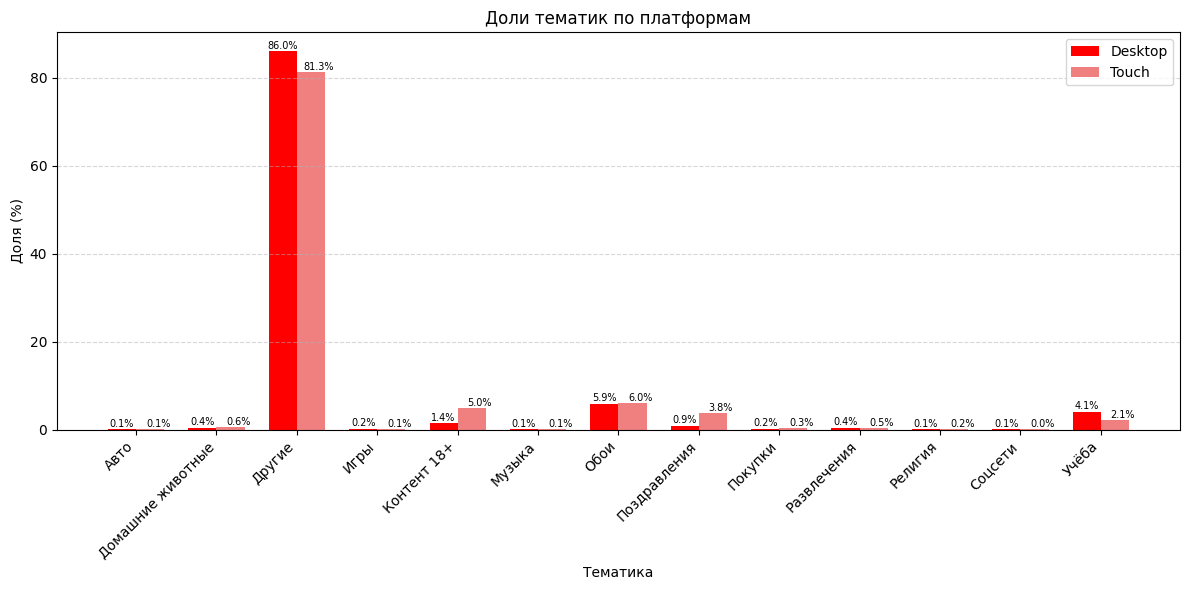

In [43]:
pivot_df = categories.pivot(index="tematika", columns="platform", values="procent").fillna(0)

tematiki = pivot_df.index.tolist()
x = np.arange(len(tematiki))  # позиции по оси X
width = 0.35  # ширина столбца

# Построение гистограммы
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, pivot_df["desktop"], width, label="Desktop", color="Red")
bars2 = ax.bar(x + width/2, pivot_df["touch"], width, label="Touch", color="lightcoral")


for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.1, f"{height:.1f}%", ha="center", va="bottom", fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2 + 0.1, height + 0.01, f"{height:.1f}%", ha="center", va="bottom", fontsize=7)

# Оформление
ax.set_xlabel("Тематика")
ax.set_ylabel("Доля (%)")
ax.set_title("Доли тематик по платформам")
ax.set_xticks(x)
ax.set_xticklabels(tematiki, rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

- **С мобильных устройств (Touch)** заметно выше доля запросов, связанных с:
  - 🎂 **Поздравлениями** — вероятно, пользователи быстро ищут открытки и поздравления в мессенджерах;
  - 🔞 **Контентом 18+** — такие запросы чаще поступают с телефонов;
- **С компьютеров (Desktop)** чаще ищут:
  - 📚 **Учебные материалы** — таблицы, алфавит, школьные задания и т.п.;
- Большая часть запросов попадает в категорию **«Другие»**, но и здесь видно, что телефоны доминируют по общему количеству.